# **Facial Expression Recognition Training Notebook**
## **Week 6**
### Sara Manrriquez

In this notebook we will explore the effects of the pretrained model ResNet50 on the facial expression recognition data. ResNet50 is a transfer learning model that was trained on ImageNet, a large dataset of annotated photographs. The benefits of ResNet50 include accelerated training and help with the vanishing gradient problem.

## Import Packages

We import all necessary packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Model

## Load Training DataFrame

We load the training data and view the first 5 rows.

In [2]:
train = pd.read_csv('/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv')
print(train.shape)

(28709, 2)


In [3]:
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


## Preprocess Data

The images for this training set are stored as a string. In order to train the model and visualize the images we need to process these strings into a 4D array of pixel values.

In [4]:
train['pixels'] = [np.fromstring(x, dtype=int, sep=' ').reshape(-1,48,48) for x in train['pixels']]

In [5]:
pixels = np.concatenate(train['pixels'])
labels = train.emotion.values

print(pixels.shape)
print(labels.shape)

(28709, 48, 48)
(28709,)


## Label Distribution

Let's view the distribution of labels.

In [6]:
emotion_prop = (train.emotion.value_counts() / len(train)).to_frame().sort_index(ascending=True)

emotion_prop

,emotion
0,0.139155
1,0.015187
2,0.142708
3,0.251315
4,0.168240
5,0.110453
6,0.172942


In [7]:
emotions = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

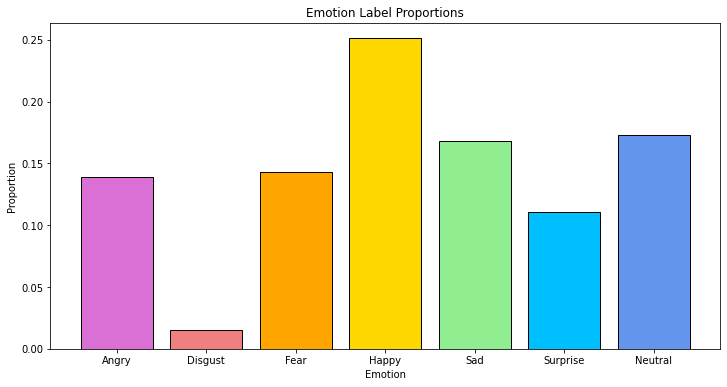

In [8]:
palette = ['orchid', 'lightcoral', 'orange', 'gold', 'lightgreen', 'deepskyblue', 'cornflowerblue']

plt.figure(figsize=[12,6])

plt.bar(x=emotions, height=emotion_prop['emotion'], color=palette, edgecolor='black')
    
plt.xlabel('Emotion')
plt.ylabel('Proportion')
plt.title('Emotion Label Proportions')
plt.show()

As we can see from the distribution of labels, there is a class imbalance within this training set: the emotion happy accounts for about 25% of the data.

## View Sample of Images

We view a sample of images for each emotion: angry, disgust, fear, happy, sad, surprise, and neutral.

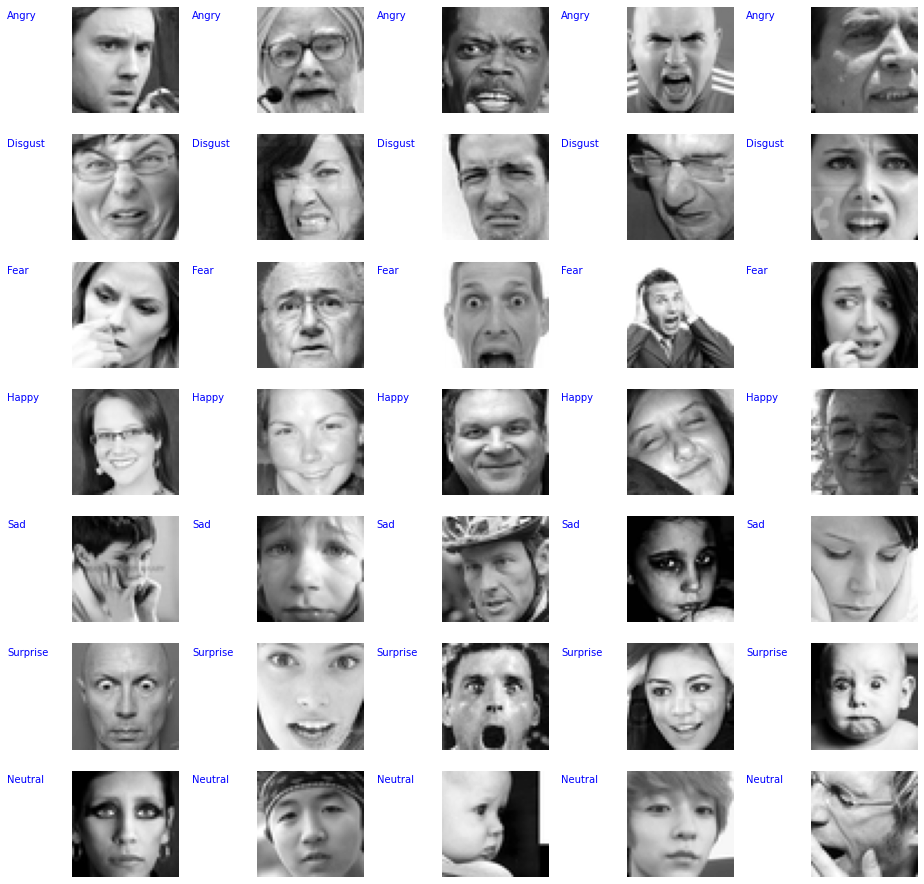

In [9]:
plt.close()
plt.rcParams["figure.figsize"] = [16,16]

row = 0
for emotion in np.unique(labels):

    all_emotion_images = train[train['emotion'] == emotion]
    for i in range(5):
        
        img = all_emotion_images.iloc[i,].pixels.reshape(48,48)
        lab = emotions[emotion]

        plt.subplot(7,5,row+i+1)
        plt.imshow(img, cmap='binary_r')
        plt.text(-30, 5, s = str(lab), fontsize=10, color='b')
        plt.axis('off')
    row += 5

plt.show()

## Split, Reshape, and Scale Datasets

We split the data into training and validation sets using a stratified fashion.

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(
    pixels, labels, test_size=0.2, stratify=labels, random_state=1
)


print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print()
print('X_valid Shape:', X_valid.shape)
print('y_valid Shape:', y_valid.shape)

X_train Shape: (22967, 48, 48)
y_train Shape: (22967,)

X_valid Shape: (5742, 48, 48)
y_valid Shape: (5742,)


ResNet50 was trained with RGB images, and our data is in grayscale. In order to use the pretrained weights of the ResNet50 model we need to convert the single grayscale channel of our images into 3 channels (RGB).

In [11]:
rgb_X_train = np.repeat(X_train[..., np.newaxis], 3, -1)
print(rgb_X_train.shape)

rgb_X_valid = np.repeat(X_valid[..., np.newaxis], 3, -1)
print(rgb_X_valid.shape)

(22967, 48, 48, 3)
(5742, 48, 48, 3)


## Image Augmentation

In an effort to prevent overfitting, we use image augmentation to create additional training observations.

In [12]:
train_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.3, 
    height_shift_range = 0.3, 
    zoom_range = 0.3, 
    horizontal_flip = True, 
    fill_mode = 'reflect'
)

train_loader = train_datagen.flow(rgb_X_train, y_train, batch_size=64)

## Transfer Learning with ResNet50

We load the pretrained ResNet50 model and set trainable to false. 

In [13]:
resnet_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False, weights='imagenet', input_shape=(48,48,3))

resnet_model.trainable = False

2021-12-11 04:42:39.933025: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-11 04:42:40.044584: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-11 04:42:40.045305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-11 04:42:40.046399: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 1s 0us/step


We view the model summary and plot the model's architecture. 

In [14]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

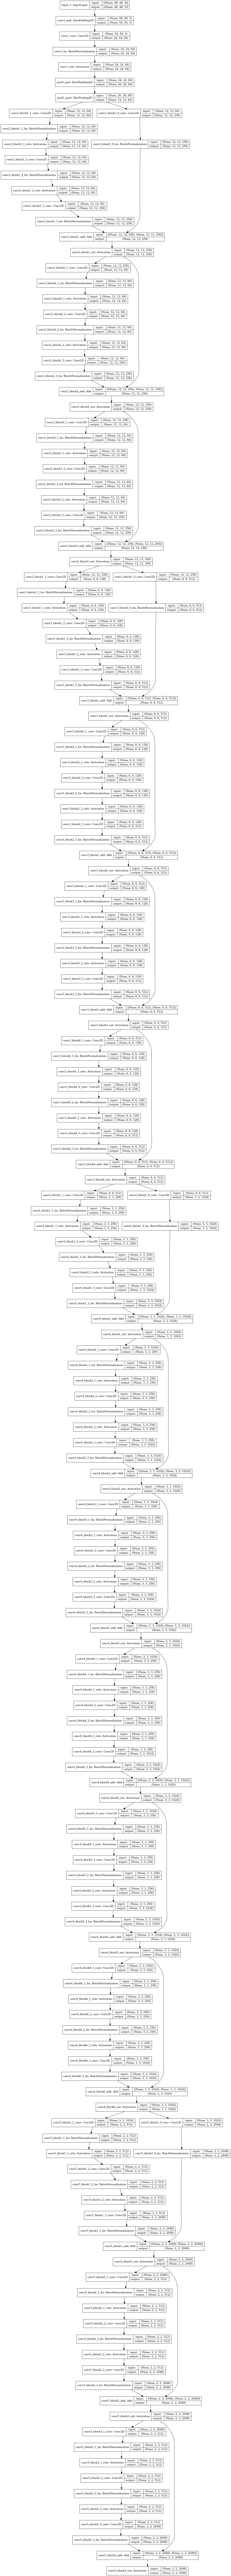

In [15]:
tf.keras.utils.plot_model(resnet_model, show_shapes=True)

## Configure Model

To the ResNet50 model we add densely-connected layers, incorporating dropout and batch normalization.

In [16]:
np.random.seed(1)
tf.random.set_seed(1)

cnn = Sequential([
    resnet_model,
    BatchNormalization(),

    Flatten(),
    
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.7),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.7),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(7, activation='softmax')
])

cnn.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 2, 2048)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1

## Train Model

We train the model using the Adam optimizer, a learning rate of 0.0001, and sparse categorical crossentropy loss.

In [17]:
opt = tf.keras.optimizers.Adam(0.0001)
cnn.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

We train the model for 30 epochs. 

In [18]:
%%time 

h1 = cnn.fit(
    train_loader, 
    batch_size=32,
    epochs = 30,
    verbose = 1,
    validation_data = (rgb_X_valid, y_valid)
)

2021-12-11 04:42:50.012801: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2021-12-11 04:42:54.336578: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


359/359 [==============================] - 36s 74ms/step - loss: 2.9185 - accuracy: 0.1577 - val_loss: 1.8290 - val_accuracy: 0.3037
Epoch 2/30
359/359 [==============================] - 25s 69ms/step - loss: 2.5917 - accuracy: 0.1891 - val_loss: 1.7620 - val_accuracy: 0.3276
Epoch 3/30
359/359 [==============================] - 25s 71ms/step - loss: 2.4087 - accuracy: 0.2047 - val_loss: 1.7645 - val_accuracy: 0.3255
Epoch 4/30
359/359 [==============================] - 26s 71ms/step - loss: 2.2808 - accuracy: 0.2145 - val_loss: 1.7409 - val_accuracy: 0.3318
Epoch 5/30
359/359 [==============================] - 28s 78ms/step - loss: 2.1789 - accuracy: 0.2274 - val_loss: 1.7245 - val_accuracy: 0.3243
Epoch 6/30
359/359 [==============================] - 26s 72ms/step - loss: 2.1158 - accuracy: 0.2309 - val_loss: 1.7173 - val_accuracy: 0.3232
Epoch 7/30
359/359 [==============================] - 25s 70ms/step - loss: 2.0488 - accuracy: 0.2400 - val_loss: 1.7092 - val_accuracy: 0.3229
Epo

In [19]:
history = h1.history
print(history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


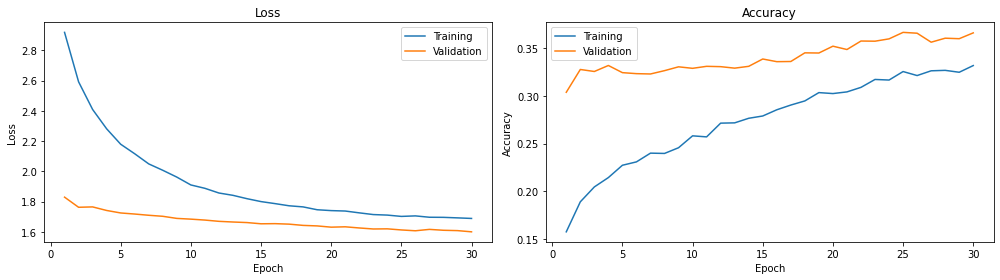

In [20]:
epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

From the learning curves we can see there is slight overfitting, and the model could benefit from additional epochs.

## Fine-Tune Model

In an effort to enhance our model's performance, we will allow the ResNet50 model to retrain.

In [21]:
resnet_model.trainable = True
tf.keras.backend.set_value(cnn.optimizer.learning_rate, 0.00001)
cnn.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [22]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 2, 2048)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1

We train the model for 30 epochs. 

In [23]:
%%time 

h2 = cnn.fit(
    train_loader, 
    batch_size=32,
    epochs = 30,
    verbose = 1,
    validation_data = (rgb_X_valid, y_valid)
)

Epoch 1/30
359/359 [==============================] - 41s 98ms/step - loss: 1.7379 - accuracy: 0.2999 - val_loss: 1.6581 - val_accuracy: 0.3622
Epoch 2/30
359/359 [==============================] - 33s 91ms/step - loss: 1.6875 - accuracy: 0.3312 - val_loss: 1.5708 - val_accuracy: 0.3889
Epoch 3/30
359/359 [==============================] - 30s 84ms/step - loss: 1.6626 - accuracy: 0.3446 - val_loss: 1.5434 - val_accuracy: 0.4039
Epoch 4/30
359/359 [==============================] - 33s 93ms/step - loss: 1.6462 - accuracy: 0.3538 - val_loss: 1.5143 - val_accuracy: 0.4126
Epoch 5/30
359/359 [==============================] - 31s 86ms/step - loss: 1.6270 - accuracy: 0.3634 - val_loss: 1.4989 - val_accuracy: 0.4208
Epoch 6/30
359/359 [==============================] - 33s 91ms/step - loss: 1.6070 - accuracy: 0.3704 - val_loss: 1.4863 - val_accuracy: 0.4279
Epoch 7/30
359/359 [==============================] - 31s 86ms/step - loss: 1.5977 - accuracy: 0.3819 - val_loss: 1.4686 - val_accuracy:

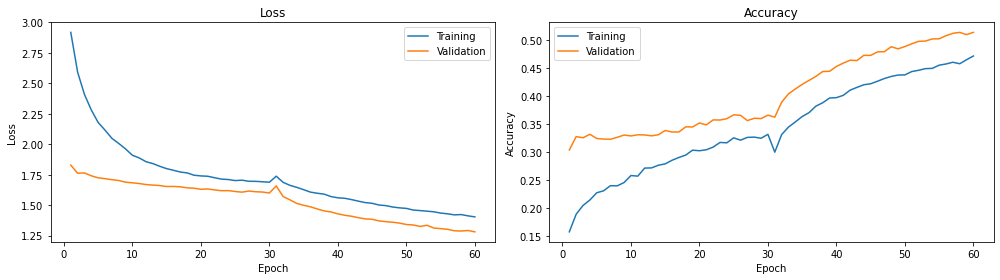

In [24]:
for k in history.keys():
    history[k] += h2.history[k]

epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

From the learning curves we can see retraining the model increase the accuracy from ~30% to ~44%; however, there is still unerfitting present. 

## Train Final Convolutional Layers

In an effort to enhance the model's performance, we will retrain the top convolutional layers of the ResNet50 model. 

In [25]:
resnet_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False, weights='imagenet', input_shape=(48,48,3))

resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [26]:
print('Number of layers in base model:', len(resnet_model.layers), '\n')

print('Names of last ten layers:')
for layer in resnet_model.layers[-10:]:
    print(layer.name)

Number of layers in base model: 175 

Names of last ten layers:
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out


In [27]:
resnet_model.trainable = True

for layer in resnet_model.layers[:-10]:
    layer.trainable = False

To the ResNet50 model we add densely-connected layers, incorporating dropout and batch normalization.

In [28]:
np.random.seed(1)
tf.random.set_seed(1)

cnn = Sequential([
    resnet_model,
    BatchNormalization(),

    Flatten(),
    
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.7),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.7),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(7, activation='softmax')
])

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
batch_normalization_4 (Batch (None, 2, 2, 2048)        8192      
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4194816   
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)              

### Training Run 1

We train the model using the Adam optimizer, a learning rate of 0.0001, and sparse categorical crossentropy loss.

In [29]:
opt = tf.keras.optimizers.Adam(0.0001)
cnn.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

We train for 30 epochs for the first training run.

In [30]:
%%time 

h1 = cnn.fit(
    train_loader, 
    batch_size=32,
    epochs = 30,
    verbose = 1,
    validation_data = (rgb_X_valid, y_valid)
)

Epoch 1/30
359/359 [==============================] - 29s 73ms/step - loss: 2.9099 - accuracy: 0.1582 - val_loss: 1.8605 - val_accuracy: 0.3044
Epoch 2/30
359/359 [==============================] - 25s 69ms/step - loss: 2.5882 - accuracy: 0.1822 - val_loss: 1.8100 - val_accuracy: 0.3246
Epoch 3/30
359/359 [==============================] - 29s 82ms/step - loss: 2.3836 - accuracy: 0.2051 - val_loss: 1.7855 - val_accuracy: 0.3335
Epoch 4/30
359/359 [==============================] - 24s 67ms/step - loss: 2.2640 - accuracy: 0.2144 - val_loss: 1.7630 - val_accuracy: 0.3365
Epoch 5/30
359/359 [==============================] - 26s 72ms/step - loss: 2.1667 - accuracy: 0.2256 - val_loss: 1.7296 - val_accuracy: 0.3312
Epoch 6/30
359/359 [==============================] - 34s 93ms/step - loss: 2.1063 - accuracy: 0.2358 - val_loss: 1.7167 - val_accuracy: 0.3373
Epoch 7/30
359/359 [==============================] - 26s 72ms/step - loss: 2.0372 - accuracy: 0.2456 - val_loss: 1.7091 - val_accuracy:

In [31]:
history = h1.history
print(history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


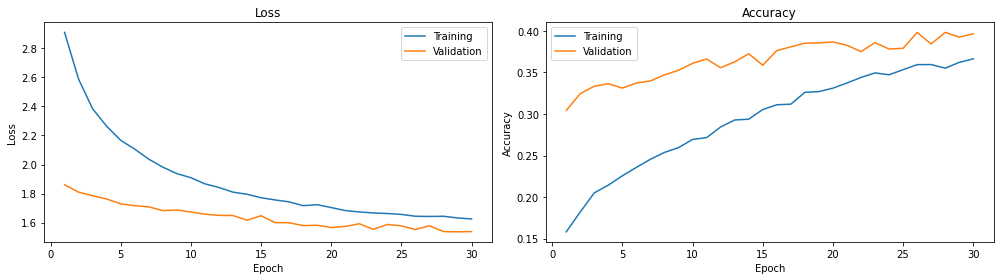

In [32]:
epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

From the learning curves we can see there is slight overfitting, and the model could benefit from additional epochs.

### Training Run 2

In order to enhance the performance of the model, we will increase the learning rate to 0.00001.

In [33]:
tf.keras.backend.set_value(cnn.optimizer.learning_rate, 0.00001)

We train for another 30 epochs for the second training run.

In [34]:
%%time 

h2 = cnn.fit(
    train_loader, 
    batch_size=32,
    epochs = 30,
    verbose = 1,
    validation_data = (rgb_X_valid, y_valid)
)

Epoch 1/30
359/359 [==============================] - 26s 74ms/step - loss: 1.6172 - accuracy: 0.3702 - val_loss: 1.5247 - val_accuracy: 0.4028
Epoch 2/30
359/359 [==============================] - 26s 72ms/step - loss: 1.6229 - accuracy: 0.3701 - val_loss: 1.5234 - val_accuracy: 0.4033
Epoch 3/30
359/359 [==============================] - 25s 71ms/step - loss: 1.6204 - accuracy: 0.3734 - val_loss: 1.5167 - val_accuracy: 0.4089
Epoch 4/30
359/359 [==============================] - 26s 71ms/step - loss: 1.6075 - accuracy: 0.3748 - val_loss: 1.5164 - val_accuracy: 0.4082
Epoch 5/30
359/359 [==============================] - 30s 85ms/step - loss: 1.6081 - accuracy: 0.3766 - val_loss: 1.5180 - val_accuracy: 0.4051
Epoch 6/30
359/359 [==============================] - 25s 70ms/step - loss: 1.6124 - accuracy: 0.3725 - val_loss: 1.5160 - val_accuracy: 0.4072
Epoch 7/30
359/359 [==============================] - 26s 72ms/step - loss: 1.6023 - accuracy: 0.3801 - val_loss: 1.5112 - val_accuracy:

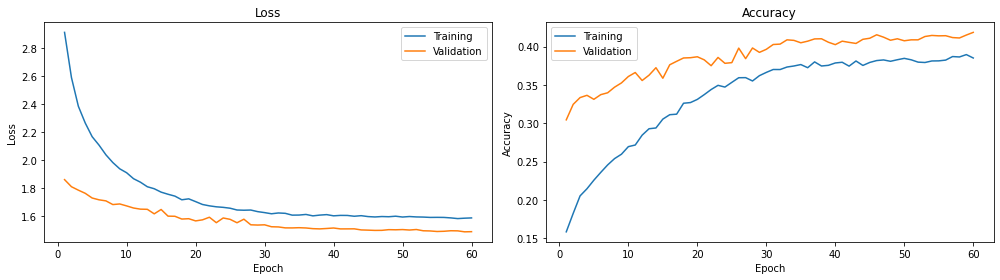

In [35]:
for k in history.keys():
    history[k] += h2.history[k]

epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

From the model we can see the accuracy improved from ~35% to ~37%; however, there is still underfitting present. 

## Save Model and History

We save the model and training history for future reference.

In [36]:
cnn.save('fer_model_v06.h5')
pickle.dump(history, open(f'fer_v06.pkl', 'wb'))

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Summary

Overall, the ResNet50 did not perform well on the facial expression recognition data. The top accuracy was ~44%. This dataset may benefit from another transfer learning model or simple architecture with the addition of image augmentation. 

## Resources

[A Comparison of 4 Popular Transfer Learning Models](https://analyticsindiamag.com/a-comparison-of-4-popular-transfer-learning-models/)<br/>
[Facial Expression Detection 2](https://www.kaggle.com/haneenabdelmaguid/facial-expression-detection-2)<br/>
[How can I use a pre-trained neural network with grayscale images?](https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images)<br/>
[Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/#do-a-round-of-finetuning-of-the-entire-model)<br/>
[Transfer Learning Tutorial (CIFAR 10)](https://www.kaggle.com/drbeane/transfer-learning-tutorial-cifar-10)